# SDS 323 Final project Notebook

**Group Members:** Jeongwook (Luke) Yun, Tiffany Nguyen, Tin Nguyen, Asmit Chakraborty

**Dataset:** CT Scans of Abdomen (https://www.cancerimagingarchive.net/collection/pancreas-ct/)

**General Project Description:** We will apply various types of machine learning and deep learning models to segment the pancreas structure from CT images of the abdomen. The models that we will evaluate are the following: random forst, traditional convolutional neural network, UNET, and vision transformer. We will compare the accuracy and errors of each model to find the best model for the segmentation task.

**Data Description:** The dataset contains image files stored in DICOM files (more formally known as Digital Imaging and Communications in Medicine format) of CT images of the abdomen. Each file corresponds with a horizontal cross-sectional image of a CT scan where each of the slices combined would create the image data for the entire abdomen area.

In [75]:
# Install dependencies if not already installed
# !pip3 install pydicom
# !pip3 install matplotlib
# !pip3 install numpy
# !pip3 install torch
# !pip3 install monai
# !pip3 install sklearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


### Reading in the Data

First, creating a class to read in and process the data in a nice format.

In [2]:
import torch
import os
import pydicom
import numpy as np
from monai.data import Dataset
from monai.transforms import LoadImage
import torch
from torch.utils.data import DataLoader
from monai.transforms import Compose, ScaleIntensity, EnsureType

class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.patients = [f for f in sorted(os.listdir(image_dir)) if "PANCREAS" in f]
        self.max_depth = self.calculate_max_depth()

    def calculate_max_depth(self):
        max_depth = 0
        for patient_folder in self.patients:
            patient_image_dir = os.path.join(self.image_dir, patient_folder)
            volume = self.load_dicom_volume(patient_image_dir)
            if volume.shape[0] > max_depth:
                max_depth = volume.shape[0]
        print("max depth: ", max_depth)
        return max_depth

    def load_dicom_volume(self, patient_image_dir):
        subfolder = next(os.walk(patient_image_dir))[1][0]
        deepest_folder = next(os.walk(os.path.join(patient_image_dir, subfolder)))[1][0]
        final_path = os.path.join(patient_image_dir, subfolder, deepest_folder)
        files = sorted(os.listdir(final_path), key=lambda x: pydicom.dcmread(os.path.join(final_path, x)).InstanceNumber)
        volume = np.stack([pydicom.dcmread(os.path.join(final_path, f)).pixel_array for f in files])
        return torch.from_numpy(volume).float()

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_folder = self.patients[idx]
        patient_image_dir = os.path.join(self.image_dir, patient_folder)
        patient_label_path = os.path.join(self.label_dir, f"label{patient_folder.split('_')[-1]}.nii.gz")
        
        volume = self.load_dicom_volume(patient_image_dir)
        label = LoadImage(image_only=True)(patient_label_path)
        label = np.transpose(label, (2, 0, 1))  # Change to (D, H, W)
        label = torch.from_numpy(label).float() 

        # Padding to maximum depth
        pad_size = self.max_depth - volume.shape[0]  # Adjust the pad for depth dimension only
        print("pad size: ", pad_size, "max depth: ", self.max_depth, "slices: ", volume.shape[0]) 
        volume = torch.nn.functional.pad(volume, (0, 0, 0, 0, 0, pad_size))  # pad last dimension (depth)
        label = torch.nn.functional.pad(label, (0, 0, 0, 0, 0, pad_size))  # pad last dimension (depth)

        # Correcting shape to (512, 512, padded_num_slices, 1)
        volume = volume.permute(2, 1, 0).unsqueeze(0)  # (C, H, W, D)
        label = label.permute(2, 1, 0).unsqueeze(0)    # (C, H, W, D)

        if self.transforms:
            volume = self.transforms(volume)
            label = self.transforms(label)

        return volume, label  # Return the tensors directly

# Set up transforms and dataloader as previously defined
transforms = Compose([
    ScaleIntensity(),
    EnsureType(dtype=torch.float32)
])

image_root_dir = "/Users/lukeyun/SDS323/manifest-1599750808610/Pancreas-CT"
label_root_dir = "/Users/lukeyun/SDS323/TCIA_pancreas_labels-02-05-2017"

dataset = MedicalImageDataset(image_root_dir, label_root_dir, transforms=transforms)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

count = 0
# Testing DataLoader
for volume, label in dataloader:
    if count < 3:
        print("Volume shape:", volume.shape, "Label shape:", label.shape)
        print("Label unique values:", torch.unique(label))
        count += 1
    else: break # Check only the first batch


max depth:  466
pad size:  260 max depth:  466 slices:  206
Volume shape: torch.Size([1, 1, 512, 512, 466]) Label shape: torch.Size([1, 1, 512, 512, 466])
Label unique values: metatensor([0., 1.])
pad size:  281 max depth:  466 slices:  185
Volume shape: torch.Size([1, 1, 512, 512, 466]) Label shape: torch.Size([1, 1, 512, 512, 466])
Label unique values: metatensor([0., 1.])
pad size:  156 max depth:  466 slices:  310
Volume shape: torch.Size([1, 1, 512, 512, 466]) Label shape: torch.Size([1, 1, 512, 512, 466])
Label unique values: metatensor([0., 1.])
pad size:  243 max depth:  466 slices:  223


The shape of the data is as above. The dimensions are, respectively, `channel`, `height`, `width`, `depth`. The `depth` dimensin varies as the patients are of nonconstant height and weight, so we have padded it with black pixels to remain at a consistent depth of $466$ slices. Also, each label has pixels that are either 0 (for not pancreas) or 1 (for pancreas)

##### 3D Volume-Label Plots

In [90]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_volume_label_pairs(volume, label):
    fig = plt.figure(figsize=(12, 6))
    
    # Volume
    ax1 = fig.add_subplot(121, projection='3d')
    x, y, z = np.indices(volume.shape) # three mesh grids that correspond to dimensions of 3D volume array
    ax1.scatter(x, y, z, c=volume.flatten(), cmap='gray') # scatter plot
    ax1.set_title('3D Volume')

    # Label
    ax2 = fig.add_subplot(122, projection='3d')
    x, y, z = np.indices(label.shape) # three mesh grids that correspond to dimensions of 3D volume array
    ax2.scatter(x, y, z, c=label.flatten(), cmap='gray') # scatter plot
    ax2.set_title('3D Label')

    plt.show()

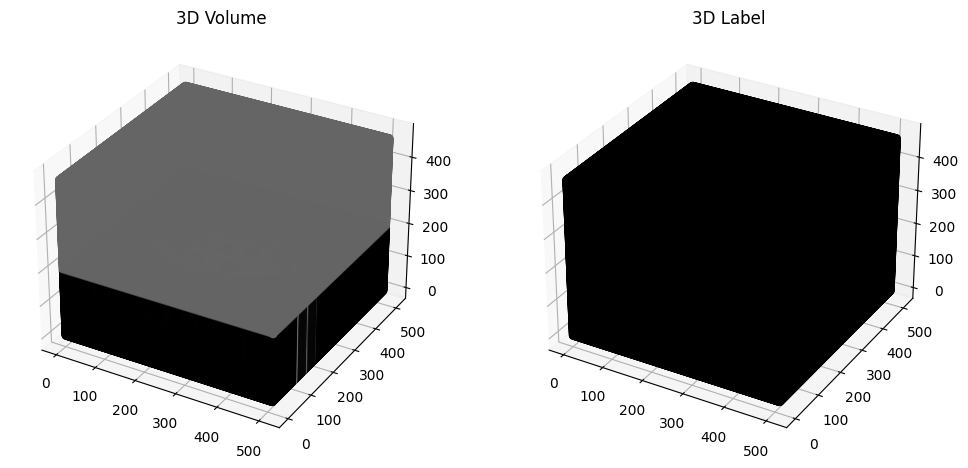

In [91]:
# NOTE: Run after initializing dataloader
# Squeezing out the batch dimension as well as the singleton channel dimension
volume, label = next(iter(dataloader))
volume = volume.squeeze().numpy()
label = label.squeeze().numpy()
plot_3d_volume_label_pairs(volume, label)

##### 2D Volume-Label Plots

In [88]:
import matplotlib.pyplot as plt

def plot_2d_volume_label_pairs(dataloader, num_pairs=5):
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 5))
    
    # Adjust for when num_pairs is 1, matplotlib only returns a single axes object
    if num_pairs == 1:
        axes = [axes]  # Wrap it in a list to make it iterable in the loop

    for i, (volume, label) in enumerate(dataloader):
        if i >= num_pairs:
            break
        
        # Handle the batch dimension explicitly, assuming batch_size=1
        volume = volume.squeeze(0)  # Squeeze out the singleton batch dimension
        label = label.squeeze(0)    # Squeeze out the singleton batch dimensio
        print(volume.shape, label.shape)

        ax1, ax2 = axes[i]
        
        # Convert the tensor to numpy for plotting and squeeze the channel dimension
        # Taking the middle depth slice of the volume for display
        # NOTE: The labels are empty sometimes -- may not be an issue since the kidney
        # might just not be located at that depth (since its the z axis of the scan)
        mid_slice_index = volume.shape[2] // 2
        volume_slice = volume[:, :, mid_slice_index].numpy()
        label_slice = label[:, :, mid_slice_index].numpy()
        
        ax1.imshow(volume_slice, cmap='gray')
        ax1.set_title(f'Patient {i+1} - Image')
        ax1.axis('off')  # Turn off axis numbers and ticks
        
        ax2.imshow(label_slice, cmap='gray')
        ax2.set_title(f'Patient {i+1} - Label')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

torch.Size([512, 512, 466, 1]) torch.Size([512, 512, 466, 1])
torch.Size([512, 512, 466, 1]) torch.Size([512, 512, 466, 1])


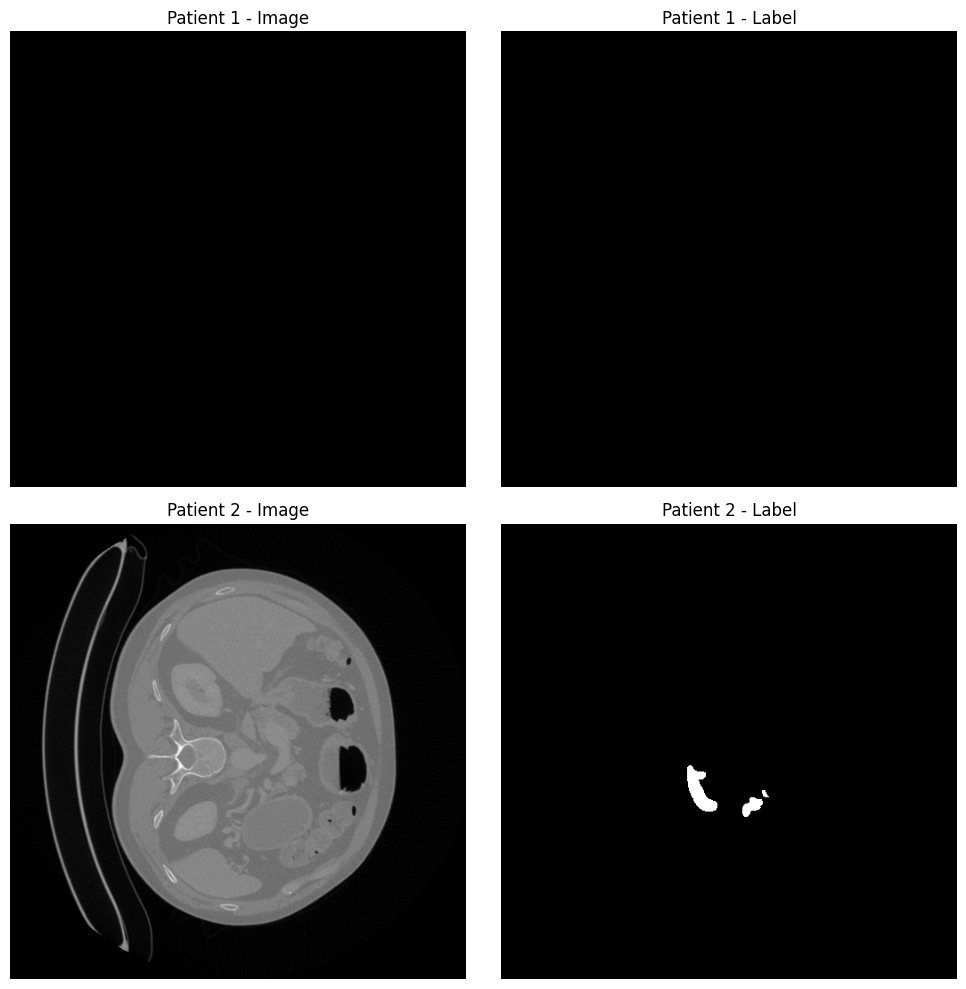

In [89]:
# Plot image-label pairs
plot_2d_volume_label_pairs(dataloader, num_pairs=2)

Noticeably, there are some slices here that are just black. This comes from the padding. Unfortunately, this blows up the data size, but is necessary to maintain a consistent data shape for our models. 

### Quick Final EDA

Something that may be worth considering is that there is a large class imbalance in the data. This is clear since there are many more visible organs than just the pancreas in a CT scan of the abdominal area.

Notably, missing data is not a concern (by the annotation of the data, we know that each patient volume has a $1:1$ correspondence with a label), 

##### Pixel Intensity Distributions

We have already seen the shape of the data and some example (padded) images. To gain some more information about the data, we look at the pixel intensities of the volumes.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_intensity_distribution(dataloader, num_batches=1, samples_per_volume=100000):
    volume_intensities = []
    label_intensities = []

    for i, (volume, label) in enumerate(dataloader):

        # Stopping criteria
        if i >= num_batches:
            break

        # Squeeze out channel and batch singleton dimensions
        volume = volume.squeeze().numpy()
        label = label.squeeze().numpy()

        # Iterate through each slice in batch
        for vol_slice, lbl_slice in zip(volume, label):

            # Filter out padding values
            non_padded_pixels = vol_slice[vol_slice > 0]  # Adjust this threshold as needed
            labeled_pixels = vol_slice[lbl_slice > 0]

            # Randomly sample pixels to reduce the data size
            if len(non_padded_pixels) > samples_per_volume:
                sampled_volume_pixels = np.random.choice(non_padded_pixels, samples_per_volume, replace=False)
            else:
                sampled_volume_pixels = non_padded_pixels
            
            if len(labeled_pixels) > samples_per_volume:
                sampled_label_pixels = np.random.choice(labeled_pixels, samples_per_volume, replace=False)
            else:
                sampled_label_pixels = labeled_pixels

            volume_intensities.extend(sampled_volume_pixels)
            label_intensities.extend(sampled_label_pixels)
    
    # Plot the histogram of the sampled intensities
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    axs[0].hist(volume_intensities, bins=256, color='skyblue', alpha=0.75)  # Adjust bins if needed
    axs[0].set_title('Pixel Intensity Distribution of Volumes')
    axs[0].set_xlabel('Pixel Intensity')
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True)

    axs[1].hist(label_intensities, bins=30, color='lightcoral', alpha=0.75)  # Adjust bins if needed
    axs[1].set_title('Pixel Intensity Distribution of Labeled Pancreas')
    axs[1].set_xlabel('Pixel Intensity')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [5]:
plot_intensity_distribution(dataloader, num_batches=5)

It seems that there are a few main neighborhoods in which pixel intensities lie in the volumes. In contrast, the label pixels seem to lie primarily in the interval $[0,25, 0.5]$ This makes sense since the volumes contain full scans of the abdomen, which would contain information about more organs than the pancreas. So, our models may want to learn to look in the above interval. 

### Modeling

Next, we begin the modeling step. We begin by splitting the data into training, validation and testing sets. Since we are no longer considering the data as a whole, we will need new dataloaders! Below is a function defined to create dataloaders corresponding to a standard $60\%, 20\%, 20\%$ split

##### Sample Splitting

In [3]:
# Remove the aggregate dataloader from memory
del dataloader

In [4]:
import torch
from torch.utils.data import DataLoader, random_split

def create_data_loaders(dataset, batch_size=1):

    # Determine sizes of each split
    total_size = len(dataset)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    # Randomly split the dataset into train, cv, and test sets
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(832) # Set seed
    )

    # Create data loaders for each split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [5]:
# Create dataloaders
dataset = MedicalImageDataset(image_root_dir, label_root_dir, transforms=transforms)
train_loader, val_loader, test_loader = create_data_loaders(dataset, batch_size=1)

max depth:  466


##### A Quick Function for Sub-Sampling **MAYBE NOT NEEDED**

There is a lot of data, so it may be helpful to sample pixels from each volume given our limited resources. Below is a function that accomplishes that given dataloaders.

In [9]:
import numpy as np

def extract_features_labels(dataloader, num_samples=10000, max_batches=10):
    features = []
    labels = []

    # Process batches from the dataloader
    for i, (volume, label) in enumerate(dataloader):

        # Stopping criteria
        if i >= max_batches:
            break
        
        # Remove singleton dimensions, convert to numpy and reshape to flatten the volume and labels
        volume = volume.squeeze().numpy()
        label = label.squeeze().numpy()

        # Flatten the data
        volume = volume.reshape(-1)  # Flatten all dimensions
        label = label.reshape(-1)  # Flatten all dimensions

        # Sample data to reduce size (optional)
        indices = np.random.choice(len(volume), min(num_samples, len(volume)), replace=False)
        sampled_features = volume[indices]
        sampled_labels = label[indices]

        # Collect data
        features.extend(sampled_features)
        labels.extend(sampled_labels)

    return np.array(features), np.array(labels)

### UNet

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2 for 3D"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv for 3D"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv for 3D"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)  # Use trilinear for 3D
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Input is CHWD, pad the spatial dimensions
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)  # Optionally reduce feature depth if too large for GPU
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Initialize U-Net for 3D
net = UNet(n_channels=1, n_classes=2)
print(net)



UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete

def train_model(model, train_loader, val_loader, device, epochs=25):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    best_val_dice = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f}')

        model.eval()
        with torch.no_grad():
            val_dice_scores = []
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                outputs = torch.sigmoid(outputs)
                outputs = AsDiscrete(threshold_values=True)(outputs)
                dice_val = dice_metric(outputs, labels)
                val_dice_scores.append(dice_val.item())

            avg_val_dice = sum(val_dice_scores) / len(val_dice_scores)
            print(f'Validation Dice Score: {avg_val_dice:.4f}')
            
            # Save the best model
            if avg_val_dice > best_val_dice:
                best_val_dice = avg_val_dice
                torch.save(model.state_dict(), 'best_unet_model.pth')
                print("Saved the new best model.")

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Create the UNet model instance
model = UNet(n_channels=1, n_classes=2)

# Create the data loaders (assuming `train_loader` and `val_loader` are already created)
# dataset = MedicalImageDataset(image_root_dir, label_root_dir, transforms=transforms)
# train_loader, val_loader, test_loader = create_data_loaders(dataset, batch_size=4)

# Start the training process
train_model(model, train_loader, val_loader, device, epochs=25)

Using device: cpu
pad size:  265 max depth:  466 slices:  201


: 

##### Random Forest

We will now fit a random forest model to the data. We chose this model because image data is very high dimensional. We also care about efficiency for this reason, reinforcing the random forest choice.

In [9]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def extract_and_flatten(data_loader):
    features = []
    labels = []
    
    # Iterate over all batches
    for volumes, labels_batch in data_loader:
        # Flatten each volume and label
        for i in range(volumes.size(0)):  # volumes.size(0) is the batch size
            current_features = volumes[i].view(-1).numpy()  # Flatten the volume
            current_labels = labels_batch[i].view(-1).numpy()  # Flatten the label
            
            features.append(current_features)
            labels.append(current_labels)

    # Convert lists to numpy arrays
    features = np.array(features, dtype=object)  # Handling potentially varying sizes if not padded
    labels = np.array(labels, dtype=object)      # Same as above

    return features, labels

def train_random_forest(train_loader, val_loader):
    # Extract and flatten training and validation data
    train_features, train_labels = extract_and_flatten(train_loader)
    val_features, val_labels = extract_and_flatten(val_loader) 

    # Flatten all data points into a single array per set
    train_features = np.concatenate(train_features)
    train_labels = np.concatenate(train_labels)
    val_features = np.concatenate(val_features)
    val_labels = np.concatenate(val_labels)
    
    # Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(train_features, train_labels)
    
    # Predict on the validation set and evaluate
    val_predictions = rf_classifier.predict(val_features)
    print("Validation Classification Report:\n", classification_report(val_labels, val_predictions))
    
    return rf_classifier

In [ ]:
rf = train_random_forest(train_loader, val_loader)